<a href="https://colab.research.google.com/github/nathanwispinski/meta-rl/blob/main/eval_and_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eval_and_analyze.ipynb

This is a Google Colab notebook to demo model evaluation and analysis of a recurrent neural network in a two-armed bandit task using reinforcement learning.

You can load your own `*.pickle` file generated from training, or use the provided `trained_agent.pickle` file.

For more details, see the GitHub repository (https://github.com/nathanwispinski/meta-rl).

# Colab setup

In [1]:
#@title Clone GitHub repository.
!git clone https://github.com/nathanwispinski/meta-rl

Cloning into 'meta-rl'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 57 (delta 22), reused 38 (delta 12), pack-reused 0
Unpacking objects: 100% (57/57), 148.95 KiB | 556.00 KiB/s, done.


In [2]:
#@title Change working directory to cloned repository (i.e., /content/meta-rl/).
%cd meta-rl

/content/meta-rl


In [3]:
# @title Install dependencies from `requirements.txt`.
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Import dependencies

In [4]:
#@title Import dependencies after install.
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import modules.envs as envs
import modules.agents as agents

# Load trained agent

In [5]:
#@title Load trained agent (your own file, or the provided `trained_agent.pickle` file).
path = "./" #@param {type:"string"}
filename = "trained_agent.pickle" #@param {type:"string"}

In [6]:
#@title Load trained agent with pickle.
with open(path + filename, 'rb') as fp:
    training_results = pickle.load(fp)

In [7]:
#@title Unpack pickle file.
params = training_results[0]['params']
training_config = training_results[0]['config']
agent_config = training_config['agent']


# Evaluation

In [8]:
#@title Initialize evaluation environment.
env = envs.BanditEnv(
    steps_per_episode=100,
    num_arms=2,
    reward_structure="correlated",
    )
observation = env.reset()

In [9]:
#@title Initialize agent.
agent = agents.create_agent(
    agent_config=agent_config,
    observation=observation,
    num_actions=env.num_actions,
)

In [10]:
#@title Setup initial LSTM memory state.
initial_lstm_state = agent.get_initial_lstm_state()
lstm_state = initial_lstm_state

In [11]:
#@title # Overwrite agent paramters with saved training parameters.
agent.params = params

In [12]:
#@title Setup evaluation episodes to test the agent on.

# Make evaluation episodes
arm1_probs = np.arange(101)/100
arm2_probs = 1. - arm1_probs

eval_episodes = np.arange(len(arm1_probs))

# Initialize data to save
eval_actions = np.zeros((len(arm1_probs), env._steps_per_episode))
eval_actions[:] = np.nan

In [13]:
#@title Evaluation loop.
for (arm1_prob, arm2_prob, ep) in zip(arm1_probs, arm2_probs, eval_episodes):
    
    step = 0
    done = False
    lstm_state = initial_lstm_state
    observation = env.reset(arm_probs=np.array([arm1_prob, arm2_prob]))
    
    while not done:

        action, pi_out, v_out, new_lstm_state, _ = agent.get_action(observation, lstm_state)
        next_observation, reward, done, info = env.step(action)

        # Save data
        eval_actions[ep, step] = action

        observation = next_observation
        lstm_state = new_lstm_state
        step += 1

print("Done evaluation.")

Done evaluation.


# Analysis

In [14]:
#@title Figure parameters.
tick_fontsize = 16
label_fontsize = 20

In [15]:
#@title Setup y tick labels to convey arm win probabilities.
ytick_vals = [0, eval_episodes[int(len(eval_episodes)/2)], eval_episodes[-1]]
ytick_labels = []
for i in ytick_vals:
    cur_probs = str(int(arm1_probs[i]*100)) + ", " + str(int(arm2_probs[i]*100))
    ytick_labels.append(cur_probs)

In [16]:
#@title Setup custom legend.
cmap_name = 'tab20c'
cmap = matplotlib.cm.get_cmap(cmap_name)
zero_color = cmap(0.)
one_color = cmap(1.)
patch1 = mpatches.Patch(color=zero_color, label='Arm 1')
patch2 = mpatches.Patch(color=one_color, label='Arm 2')

In [17]:
#@title Define plotting function.

def plot_action_results(data):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.imshow(data, cmap='tab20c', origin='lower')
    plt.yticks(
        ticks=ytick_vals,
        labels=ytick_labels,
        fontsize=tick_fontsize,
        )
    plt.xticks(
        ticks=[0, env._steps_per_episode],
        labels=[0, env._steps_per_episode],
        fontsize=tick_fontsize,
        )
    plt.xlabel("Trials", fontsize=label_fontsize)
    plt.ylabel("Arm win probabilities \n (Arm 1 %, Arm 2 %)", fontsize=label_fontsize)
    ax.spines[['right', 'top']].set_visible(False)
    plt.legend(handles=[patch1, patch2],
              loc='center left',
              bbox_to_anchor=(1, 0.5),
              frameon=False,
              fontsize=label_fontsize,
              borderaxespad=0.,
              )
    plt.tight_layout()
    plt.show()

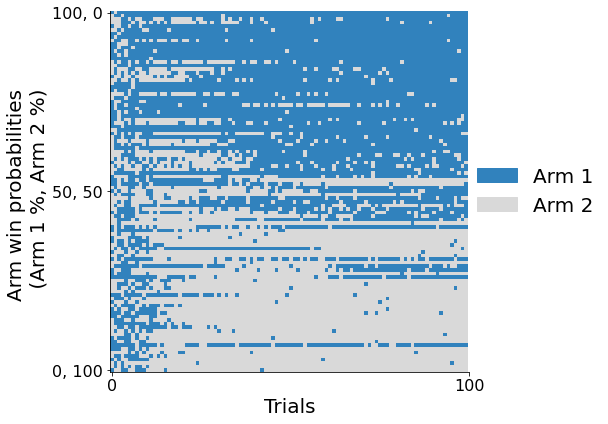

In [18]:
#@title Plot action results from our trained reinforcement learning model.
plot_action_results(eval_actions)


# Other models

We can also plot a completely random agent, and an agent with insider knowledge about the arm win probabilities, for completeness.

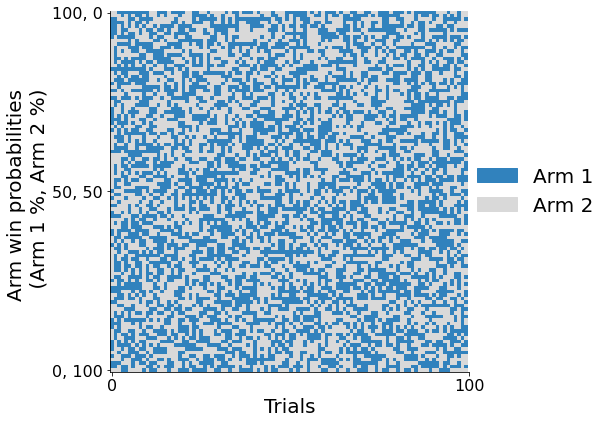

In [19]:
#@title Plot action results from a random model.

random_actions = np.random.randint(low=0, high=2, size=np.shape(eval_actions))

plot_action_results(random_actions)


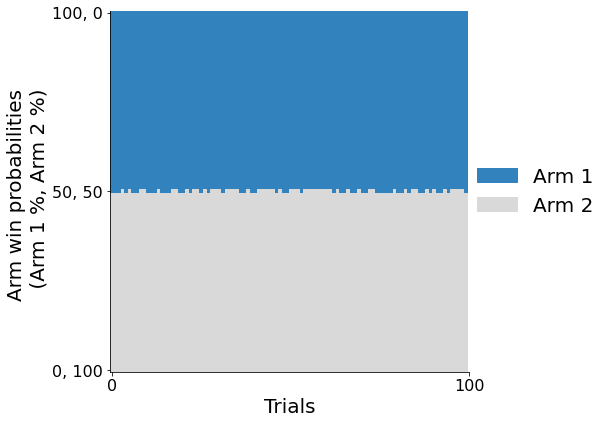

In [20]:
#@title Plot action results from a model with insider knowledge.

# Initialize data
insider_actions = np.zeros((len(arm1_probs), env._steps_per_episode))
insider_actions[:] = np.nan

for (arm1_prob, arm2_prob, ep) in zip(arm1_probs, arm2_probs, eval_episodes):
    if arm1_prob > arm2_prob:
        actions = np.zeros(env._steps_per_episode)
    elif arm1_prob == arm2_prob:
        actions = np.random.randint(low=0, high=2, size=env._steps_per_episode)
    else:
        actions = np.ones(env._steps_per_episode)
    insider_actions[ep, :] = actions

plot_action_results(insider_actions)